In [1]:
import os, random, json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
SEED = 42  
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)
NUM_CLASSES = 3

In [3]:
base_dir = 'Dataset_BUSI_with_GT'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
OUTPUT_DIR = "outputs_resnet50"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
print("Benign:", len(os.listdir(os.path.join(train_dir, 'benign'))))
print("Malignant:", len(os.listdir(os.path.join(train_dir, 'malignant'))))
print("Normal:", len(os.listdir(os.path.join(train_dir, 'normal'))))

Benign: 814
Malignant: 805
Normal: 802


In [7]:
HEAD_EPOCHS = 5
FT_EPOCHS = 20
PATIENCE = 3
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FT   = 1e-5
UNFREEZE_LAST_N = 15

In [8]:
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [9]:
#Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2421 images belonging to 3 classes.
Found 517 images belonging to 3 classes.
Found 522 images belonging to 3 classes.


In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
output_layer = layers.Dense(NUM_CLASSES, activation="softmax")(x)


In [12]:
model = models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [14]:
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_HEAD), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(os.path.join(OUTPUT_DIR,"best_head.h5"), save_best_only=True, monitor='val_loss')
reduceLR = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [ ]:
# Train the head
history_head = model.fit(
    train_generator,
    epochs=HEAD_EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/5


152/152 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.3544

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


152/152 [==============================] - 249s 2s/step - loss: 1.2036 - accuracy: 0.3544 - val_loss: 1.1466 - val_accuracy: 0.3366
Epoch 2/5
152/152 [==============================] - 172s 1s/step - loss: 1.1317 - accuracy: 0.3651 - val_loss: 1.1061 - val_accuracy: 0.3617
Epoch 3/5
152/152 [==============================] - 171s 1s/step - loss: 1.1165 - accuracy: 0.3684 - val_loss: 1.0726 - val_accuracy: 0.3617
Epoch 4/5
152/152 [==============================] - 191s 1s/step - loss: 1.1024 - accuracy: 0.3833 - val_loss: 1.0640 - val_accuracy: 0.4642
Epoch 5/5
152/152 [==============================] - 191s 1s/step - loss: 1.0853 - accuracy: 0.3891 - val_loss: 1.0628 - val_accuracy: 0.4081


In [ ]:
# Unfreeze the last N layers of the base model
total = len(base_model.layers)
for i, layer in enumerate(base_model.layers):
    if i >= total - UNFREEZE_LAST_N:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_FT), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the fine-tuned model

history_ft = model.fit(
    train_generator,
    epochs=FT_EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduceLR]
)

Epoch 1/20
152/152 [==============================] - 213s 1s/step - loss: 1.0749 - accuracy: 0.4544 - val_loss: 1.0797 - val_accuracy: 0.3810 - lr: 1.0000e-05
Epoch 2/20
152/152 [==============================] - 203s 1s/step - loss: 0.9812 - accuracy: 0.5221 - val_loss: 0.9937 - val_accuracy: 0.5164 - lr: 1.0000e-05
Epoch 3/20
152/152 [==============================] - 193s 1s/step - loss: 0.9270 - accuracy: 0.5721 - val_loss: 0.9155 - val_accuracy: 0.6074 - lr: 1.0000e-05
Epoch 4/20
152/152 [==============================] - 207s 1s/step - loss: 0.8792 - accuracy: 0.6006 - val_loss: 0.8006 - val_accuracy: 0.6480 - lr: 1.0000e-05
Epoch 5/20
152/152 [==============================] - 161s 1s/step - loss: 0.8385 - accuracy: 0.6241 - val_loss: 0.8014 - val_accuracy: 0.6228 - lr: 1.0000e-05
Epoch 6/20
152/152 [==============================] - 191s 1s/step - loss: 0.7916 - accuracy: 0.6613 - val_loss: 0.7220 - val_accuracy: 0.7176 - lr: 1.0000e-05
Epoch 7/20
152/152 [====================

In [ ]:
# Evaluate the model
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
pred_probs = model.predict(test_generator, steps=test_steps)
pred_classes = np.argmax(pred_probs, axis=1)[:test_generator.samples]
true_classes = test_generator.classes[:len(pred_classes)]

33/33 [==============================] - 38s 960ms/step


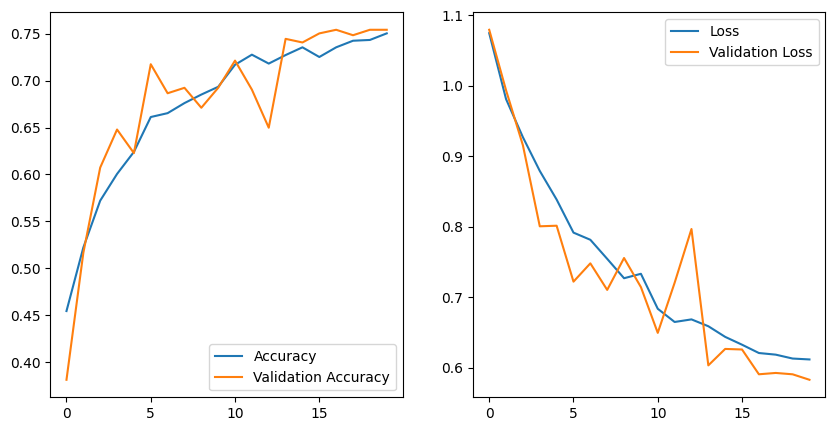

In [ ]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history_ft.history['accuracy']
val_acc =  history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
idx_to_class = {v:k for k,v in test_generator.class_indices.items()}
class_labels = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
df_preds = pd.DataFrame(pred_probs[:len(pred_classes)], columns=[f"prob_{c}" for c in class_labels])
df_preds["pred"] = pred_classes
df_preds["true"] = true_classes
df_preds["filename"] = test_generator.filenames[:len(pred_classes)]
df_preds.to_csv(os.path.join(OUTPUT_DIR, "test_predictions.csv"), index=False)

              precision    recall  f1-score   support

      benign       0.73      0.60      0.66       176
   malignant       0.71      0.82      0.76       173
      normal       0.77      0.80      0.78       173

    accuracy                           0.74       522
   macro avg       0.74      0.74      0.73       522
weighted avg       0.74      0.74      0.73       522



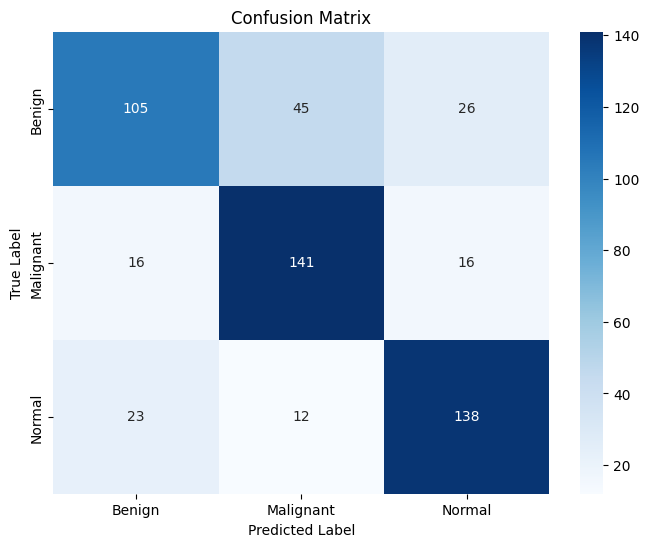

In [ ]:
# Classification report and confusion matrix
print(classification_report(true_classes, pred_classes, target_names=class_labels))


cm = confusion_matrix(true_classes, pred_classes)

class_labels = ['Benign', 'Malignant', 'Normal']

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

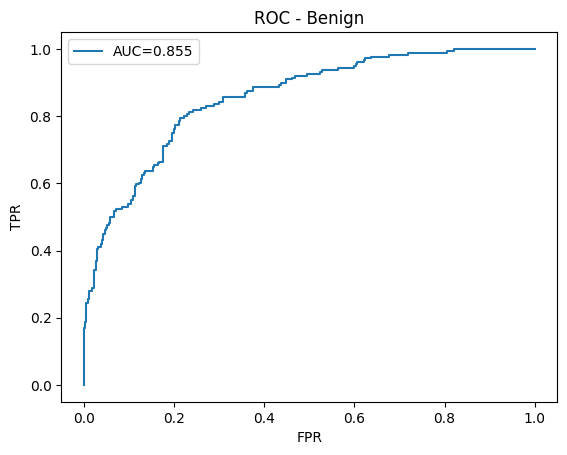

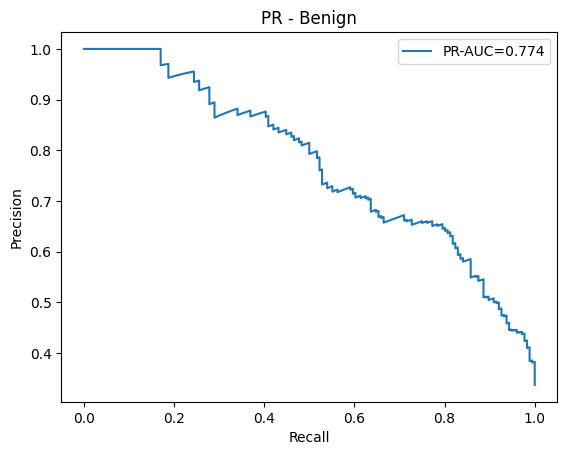

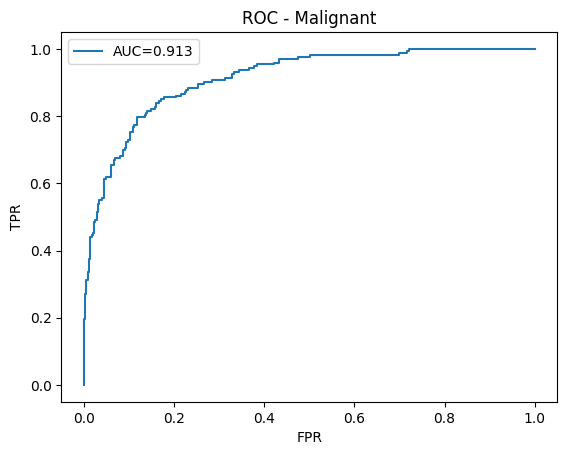

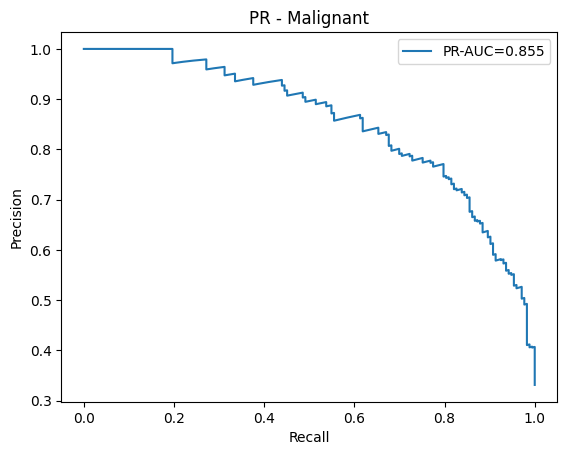

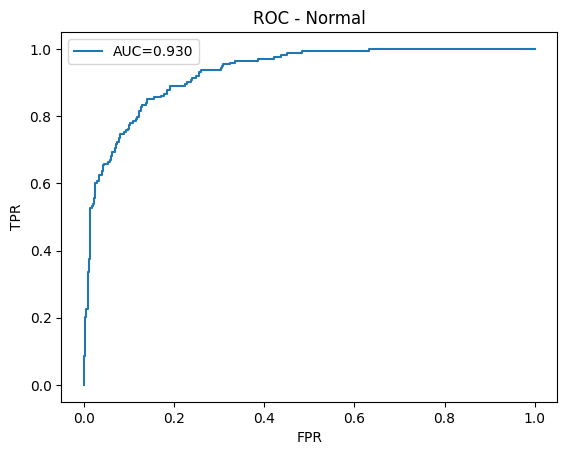

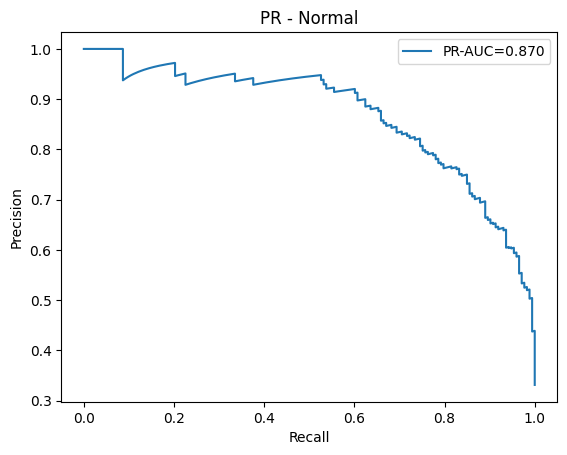

In [ ]:
# ROC and PR curves
y_true_bin = label_binarize(true_classes, classes=sorted(idx_to_class.keys()))
for i, cls in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    auc_val = roc_auc_score(y_true_bin[:, i], pred_probs[:, i])
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {cls}"); plt.legend()
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true_bin[:, i], pred_probs[:, i])
    pr_val = average_precision_score(y_true_bin[:, i], pred_probs[:, i])
    plt.figure(); plt.plot(rec, prec, label=f"PR-AUC={pr_val:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR - {cls}"); plt.legend()
    plt.show()